In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusion import DiffusionModel
from models import UNet
from google.colab import drive
drive.mount('/content/drive')

img_path = '/content/drive/MyDrive/sprites_1788_16x16.npy'
labels_path = '/content/drive/MyDrive/sprite_labels_nc_1788_16x16.npy'

images = np.load(img_path)
labels = np.load(labels_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
labels.shape

(89400, 5)

In [3]:
images.shape

(89400, 16, 16, 3)

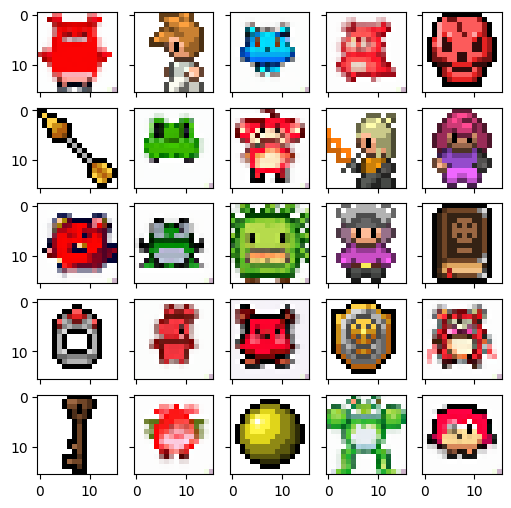

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = images[random_characters]
    fig_x.imshow(im_val)
    fig_x.grid(False)

In [5]:
import torch
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.data = (torch.Tensor(np.transpose(images, (0, 3, 1, 2)) / 255) - 0.5) * 2
        self.labels = torch.argmax(torch.Tensor(labels), dim=1, keepdim=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [6]:
dataset = ImageDataset(images, labels)
batch_size = 256
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## DDPM predicting noise

In [ ]:
n_steps = 1000

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps)

In [ ]:
n_epochs = 30
diffusion_model.train(n_epochs, data_loader, len(dataset))

  3%|▎         | 1/30 [00:33<16:25, 33.97s/it]

Loss at epoch 1: 0.223



  7%|▋         | 2/30 [01:05<15:05, 32.35s/it]

Loss at epoch 2: 0.098



 10%|█         | 3/30 [01:36<14:22, 31.96s/it]

Loss at epoch 3: 0.080



 13%|█▎        | 4/30 [02:08<13:45, 31.76s/it]

Loss at epoch 4: 0.070



 17%|█▋        | 5/30 [02:39<13:07, 31.49s/it]

Loss at epoch 5: 0.064



 20%|██        | 6/30 [03:10<12:34, 31.45s/it]

Loss at epoch 6: 0.059



 23%|██▎       | 7/30 [03:42<12:04, 31.52s/it]

Loss at epoch 7: 0.055



 27%|██▋       | 8/30 [04:13<11:29, 31.32s/it]

Loss at epoch 8: 0.051



 30%|███       | 9/30 [04:46<11:10, 31.91s/it]

Loss at epoch 9: 0.048



 33%|███▎      | 10/30 [05:18<10:39, 31.96s/it]

Loss at epoch 10: 0.045



 37%|███▋      | 11/30 [05:49<10:03, 31.77s/it]

Loss at epoch 11: 0.042



 40%|████      | 12/30 [06:22<09:37, 32.11s/it]

Loss at epoch 12: 0.040



 43%|████▎     | 13/30 [06:54<09:06, 32.17s/it]

Loss at epoch 13: 0.038



 47%|████▋     | 14/30 [07:26<08:31, 31.96s/it]

Loss at epoch 14: 0.037



 50%|█████     | 15/30 [07:58<07:59, 31.98s/it]

Loss at epoch 15: 0.035



 53%|█████▎    | 16/30 [08:31<07:30, 32.18s/it]

Loss at epoch 16: 0.034



 57%|█████▋    | 17/30 [09:02<06:56, 32.06s/it]

Loss at epoch 17: 0.033



 60%|██████    | 18/30 [09:35<06:25, 32.13s/it]

Loss at epoch 18: 0.032



 63%|██████▎   | 19/30 [10:08<05:56, 32.37s/it]

Loss at epoch 19: 0.030



 67%|██████▋   | 20/30 [10:40<05:23, 32.37s/it]

Loss at epoch 20: 0.030



 70%|███████   | 21/30 [11:13<04:52, 32.54s/it]

Loss at epoch 21: 0.029



 73%|███████▎  | 22/30 [11:45<04:20, 32.53s/it]

Loss at epoch 22: 0.028



 77%|███████▋  | 23/30 [12:18<03:47, 32.48s/it]

Loss at epoch 23: 0.027



 80%|████████  | 24/30 [12:50<03:14, 32.46s/it]

Loss at epoch 24: 0.026



 83%|████████▎ | 25/30 [13:22<02:41, 32.24s/it]

Loss at epoch 25: 0.025



 87%|████████▋ | 26/30 [13:54<02:09, 32.31s/it]

Loss at epoch 26: 0.026



 90%|█████████ | 27/30 [14:26<01:36, 32.12s/it]

Loss at epoch 27: 0.026



 93%|█████████▎| 28/30 [14:58<01:04, 32.05s/it]

Loss at epoch 28: 0.025



 97%|█████████▋| 29/30 [15:30<00:32, 32.02s/it]

Loss at epoch 29: 0.024



100%|██████████| 30/30 [16:02<00:00, 32.09s/it]

Loss at epoch 30: 0.024


In [ ]:
new_image = diffusion_model.sample(25)

1000it [00:18, 53.77it/s]


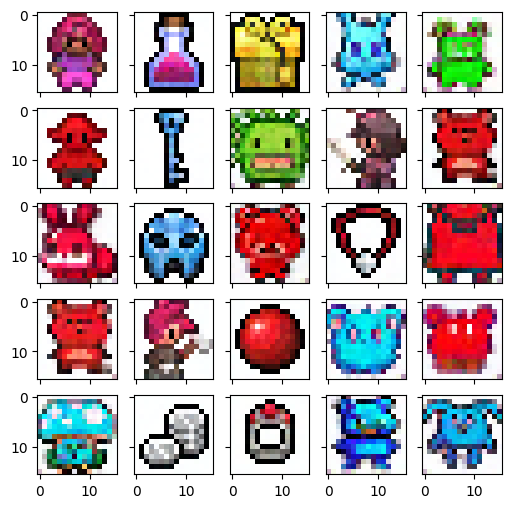

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

## DDPM predicting signal itself

In [8]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps, predict_noise=False)
n_epochs = 30
diffusion_model.train(n_epochs, data_loader, len(dataset))

  3%|▎         | 1/30 [00:32<15:44, 32.58s/it]

Loss at epoch 1: 0.249



  7%|▋         | 2/30 [01:01<14:14, 30.51s/it]

Loss at epoch 2: 0.190



 10%|█         | 3/30 [01:31<13:37, 30.26s/it]

Loss at epoch 3: 0.178



 13%|█▎        | 4/30 [02:01<13:05, 30.20s/it]

Loss at epoch 4: 0.170



 17%|█▋        | 5/30 [02:31<12:34, 30.17s/it]

Loss at epoch 5: 0.164



 20%|██        | 6/30 [03:01<12:03, 30.14s/it]

Loss at epoch 6: 0.160



 23%|██▎       | 7/30 [03:33<11:42, 30.56s/it]

Loss at epoch 7: 0.158



 27%|██▋       | 8/30 [04:04<11:16, 30.76s/it]

Loss at epoch 8: 0.155



 30%|███       | 9/30 [04:35<10:44, 30.71s/it]

Loss at epoch 9: 0.153



 33%|███▎      | 10/30 [05:06<10:16, 30.80s/it]

Loss at epoch 10: 0.151



 37%|███▋      | 11/30 [05:37<09:45, 30.83s/it]

Loss at epoch 11: 0.150



 40%|████      | 12/30 [06:08<09:16, 30.90s/it]

Loss at epoch 12: 0.148



 43%|████▎     | 13/30 [06:40<08:54, 31.47s/it]

Loss at epoch 13: 0.148



 47%|████▋     | 14/30 [07:17<08:48, 33.00s/it]

Loss at epoch 14: 0.148



 50%|█████     | 15/30 [07:48<08:08, 32.57s/it]

Loss at epoch 15: 0.145



 53%|█████▎    | 16/30 [08:23<07:43, 33.10s/it]

Loss at epoch 16: 0.144



 57%|█████▋    | 17/30 [08:54<07:04, 32.66s/it]

Loss at epoch 17: 0.145



 60%|██████    | 18/30 [09:25<06:25, 32.12s/it]

Loss at epoch 18: 0.143



 63%|██████▎   | 19/30 [09:58<05:55, 32.32s/it]

Loss at epoch 19: 0.142



 67%|██████▋   | 20/30 [10:29<05:18, 31.88s/it]

Loss at epoch 20: 0.141



 70%|███████   | 21/30 [11:01<04:48, 32.02s/it]

Loss at epoch 21: 0.141



 73%|███████▎  | 22/30 [11:33<04:14, 31.80s/it]

Loss at epoch 22: 0.139



 77%|███████▋  | 23/30 [12:04<03:41, 31.60s/it]

Loss at epoch 23: 0.141



 80%|████████  | 24/30 [12:35<03:09, 31.53s/it]

Loss at epoch 24: 0.138



 83%|████████▎ | 25/30 [13:06<02:37, 31.42s/it]

Loss at epoch 25: 0.139



 87%|████████▋ | 26/30 [13:38<02:06, 31.52s/it]

Loss at epoch 26: 0.138



 90%|█████████ | 27/30 [14:09<01:34, 31.39s/it]

Loss at epoch 27: 0.137



 93%|█████████▎| 28/30 [14:40<01:02, 31.35s/it]

Loss at epoch 28: 0.137



 97%|█████████▋| 29/30 [15:12<00:31, 31.29s/it]

Loss at epoch 29: 0.137



100%|██████████| 30/30 [15:43<00:00, 31.45s/it]

Loss at epoch 30: 0.136


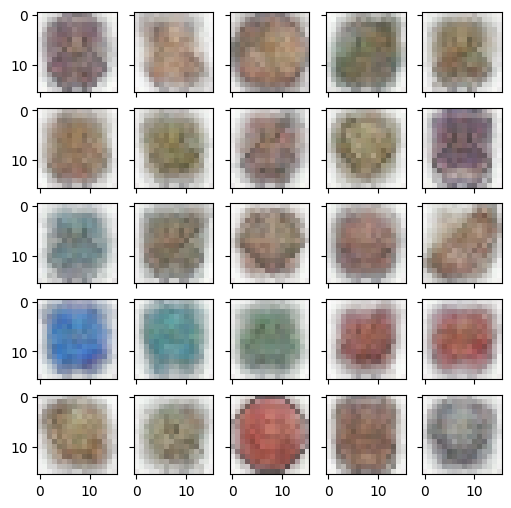

In [11]:
new_image = diffusion_model.sample_start(25)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)

## Conditional ddpm

In [8]:
n_steps = 500

model = UNet(in_channels=3, out_channels=3, n_steps=n_steps, n_classes=5).to(device)
diffusion_model = DiffusionModel(model, img_size=16, n_steps=n_steps)
n_epochs = 30
diffusion_model.train_cond(n_epochs, data_loader, len(dataset))

  3%|▎         | 1/30 [00:31<15:06, 31.26s/it]

Loss at epoch 1: 0.254



  7%|▋         | 2/30 [01:01<14:18, 30.67s/it]

Loss at epoch 2: 0.129



 10%|█         | 3/30 [01:32<13:54, 30.92s/it]

Loss at epoch 3: 0.106



 13%|█▎        | 4/30 [02:03<13:24, 30.94s/it]

Loss at epoch 4: 0.094



 17%|█▋        | 5/30 [02:34<12:48, 30.76s/it]

Loss at epoch 5: 0.083



 20%|██        | 6/30 [03:06<12:28, 31.19s/it]

Loss at epoch 6: 0.076



 23%|██▎       | 7/30 [03:37<11:57, 31.21s/it]

Loss at epoch 7: 0.070



 27%|██▋       | 8/30 [04:08<11:25, 31.18s/it]

Loss at epoch 8: 0.065



 30%|███       | 9/30 [04:39<10:54, 31.16s/it]

Loss at epoch 9: 0.060



 33%|███▎      | 10/30 [05:10<10:21, 31.10s/it]

Loss at epoch 10: 0.056



 37%|███▋      | 11/30 [05:42<09:54, 31.31s/it]

Loss at epoch 11: 0.053



 40%|████      | 12/30 [06:13<09:21, 31.17s/it]

Loss at epoch 12: 0.050



 43%|████▎     | 13/30 [06:44<08:49, 31.13s/it]

Loss at epoch 13: 0.047



 47%|████▋     | 14/30 [07:15<08:17, 31.12s/it]

Loss at epoch 14: 0.045



 50%|█████     | 15/30 [07:47<07:49, 31.29s/it]

Loss at epoch 15: 0.043



 53%|█████▎    | 16/30 [08:18<07:17, 31.26s/it]

Loss at epoch 16: 0.041



 57%|█████▋    | 17/30 [08:49<06:46, 31.28s/it]

Loss at epoch 17: 0.040



 60%|██████    | 18/30 [09:20<06:14, 31.21s/it]

Loss at epoch 18: 0.039



 63%|██████▎   | 19/30 [09:52<05:44, 31.28s/it]

Loss at epoch 19: 0.038



 67%|██████▋   | 20/30 [10:23<05:13, 31.32s/it]

Loss at epoch 20: 0.036



 70%|███████   | 21/30 [10:54<04:41, 31.28s/it]

Loss at epoch 21: 0.035



 73%|███████▎  | 22/30 [11:26<04:10, 31.30s/it]

Loss at epoch 22: 0.034



 77%|███████▋  | 23/30 [11:57<03:39, 31.29s/it]

Loss at epoch 23: 0.033



 80%|████████  | 24/30 [12:28<03:08, 31.37s/it]

Loss at epoch 24: 0.033



 83%|████████▎ | 25/30 [13:00<02:36, 31.33s/it]

Loss at epoch 25: 0.032



 87%|████████▋ | 26/30 [13:32<02:06, 31.54s/it]

Loss at epoch 26: 0.030



 90%|█████████ | 27/30 [14:03<01:34, 31.62s/it]

Loss at epoch 27: 0.031



 93%|█████████▎| 28/30 [14:35<01:03, 31.63s/it]

Loss at epoch 28: 0.030



 97%|█████████▋| 29/30 [15:08<00:31, 31.94s/it]

Loss at epoch 29: 0.030



100%|██████████| 30/30 [15:39<00:00, 31.31s/it]

Loss at epoch 30: 0.028


In [9]:
labels = torch.Tensor([[0]] * 5 + [[1]] * 5 + [[2]] * 5 + [[3]] * 5 + [[4]] * 5).to(device).long()

500it [00:16, 30.62it/s]


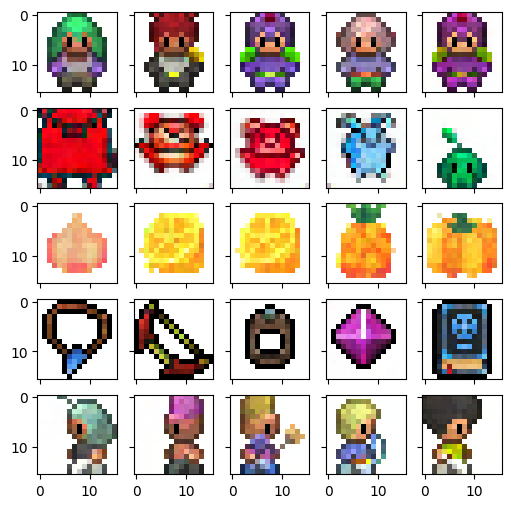

In [10]:
new_image = diffusion_model.sample(25, labels, 2)
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(6, 6), \
                        sharey=True, sharex=True)

new_images = np.transpose(new_image.to("cpu"), (0, 2, 3, 1))
for img, fig_x in zip(new_images, ax.flatten()):
    fig_x.imshow(img)
    fig_x.grid(False)